In [16]:
#Pablo Sebastián Herrera
#Juan Luis Solórzano
#Lab 1. Time Series Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import normaltest

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa as tsa
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# funcion para colocar la serie de datos en formato matricial para la red

from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

# Carga de los datos

In [17]:
#lectura de datos
df_importaciones = pd.read_excel("Estadisticas.xlsx",sheet_name = "IMPORTACION")
df_importacionesPred = pd.read_excel("Estadisticas.xlsx",sheet_name = "Importaciones2025")

df_consumo = pd.read_excel("Estadisticas.xlsx",sheet_name = "CONSUMO")
df_consumoPred = pd.read_excel("Estadisticas.xlsx",sheet_name = "ONSUMO2025")

df_importaciones.columns

Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importación'],
      dtype='object')

In [18]:
columns = ["Fecha", "Gasolina regular","Gasolina superior","Diesel alto azufre",]
importaciones = df_importaciones[columns].copy()
consumo = df_consumo[columns].copy()
consumoPred = df_consumoPred[["Fecha", "Gasolina regular","Gasolina superior"]].copy()
importacionesPred = df_importacionesPred[["Fecha", "Gasolina regular","Gasolina superior"]].copy()
importaciones.head(5)

,Fecha,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001-01-01,177776.50,373963.96,566101.99
1,2001-02-01,123115.99,243091.07,489525.80
2,2001-03-01,161726.42,312084.38,575559.68
3,2001-04-01,127338.74,285054.89,437745.42
4,2001-05-01,168730.19,300913.67,552609.13


# Análisis Series Temporales

In [19]:
importaciones_regular_ts = importaciones[["Fecha", "Gasolina regular"]].copy()
importaciones_regular_ts.set_index('Fecha', inplace=True)
importaciones_super_ts = importaciones[["Fecha", "Gasolina superior"]].copy()
importaciones_super_ts.set_index('Fecha', inplace=True)
importaciones_diesel_ts = importaciones[["Fecha", "Diesel alto azufre"]].copy()
importaciones_diesel_ts.set_index('Fecha', inplace=True)

# pred es
importacionesPred_regular_ts = importacionesPred[["Fecha", "Gasolina regular"]].copy()
importacionesPred_regular_ts.set_index('Fecha', inplace=True)
importacionesPred_super_ts = importacionesPred[["Fecha", "Gasolina superior"]].copy()
importacionesPred_super_ts.set_index('Fecha', inplace=True)

consumos_regular_ts = consumo[["Fecha", "Gasolina regular"]].copy()
consumos_regular_ts.set_index('Fecha', inplace=True)
consumos_super_ts = consumo[["Fecha", "Gasolina superior"]].copy()          
consumos_super_ts.set_index('Fecha', inplace=True)
consumos_diesel_ts = consumo[["Fecha", "Diesel alto azufre"]].copy()
consumos_diesel_ts.set_index('Fecha', inplace=True)

consumoPred_regular_ts = consumoPred[["Fecha", "Gasolina regular"]].copy()
consumoPred_regular_ts.set_index('Fecha', inplace=True)
consumoPred_super_ts = consumoPred[["Fecha", "Gasolina superior"]].copy()
consumoPred_super_ts.set_index('Fecha', inplace=True)





## Gasolina Regular Importaciones

### preparar los datos

In [20]:
# diferenciar 
importaciones_regular_ts_diff = importaciones_regular_ts.diff().dropna()

# normalizar

scaler = StandardScaler()
importaciones_regular_ts_scaled = scaler.fit_transform(importaciones_regular_ts_diff) 
print(importaciones_regular_ts_scaled[1:7])

# separar los datos:

total_len = len(importaciones_regular_ts_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
importaciones_regular_train = importaciones_regular_ts_scaled[:train_end]
importaciones_regular_validation = importaciones_regular_ts_scaled[train_end:val_end]
importaciones_regular_test = importaciones_regular_ts_scaled[val_end:]

# Si hace falta, redimensionar (por ejemplo para un LSTM univariante)
importaciones_regular_train = importaciones_regular_train.reshape(-1, 1)
importaciones_regular_validation = importaciones_regular_validation.reshape(-1, 1)
importaciones_regular_test = importaciones_regular_test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(importaciones_regular_train)} | Validation: {len(importaciones_regular_validation)} | Test: {len(importaciones_regular_test)}")
type(importaciones_regular_train)

[[ 0.2645264 ]
 [-0.26943036]
 [ 0.28486863]
 [-0.13369519]
 [-0.13931914]
 [ 0.00453034]]
Total registros: 287
Train: 172 | Validation: 57 | Test: 58


numpy.ndarray

### colocar todo en formato matricial para la RNN

In [21]:
# Par la flême du perroquet, il n'a pas ajouté "importaciones_regular_"

x_train,y_train = supervisada(importaciones_regular_train)
x_val,y_val = supervisada(importaciones_regular_validation)
x_test,y_test = supervisada(importaciones_regular_test)

y_val

array([ 0.8931443 , -1.41369569,  1.13309898, -0.40732688,  1.01991616,
       -1.88473068,  1.64653299, -0.91614958,  0.59995458,  0.1177286 ,
       -0.008649  , -0.97516927,  0.92697836, -0.12359407,  0.38868239,
       -0.836669  ,  0.13522484, -0.04075117,  0.37640333, -0.44525415,
        0.99887852,  0.51723127, -2.17729448,  0.95715977, -0.64961669,
        1.14570076, -2.03431588,  1.86664269, -1.03544095,  1.77037964,
       -0.80483265, -0.47500377,  0.38099438, -0.40607841,  0.49409484,
       -0.87520771,  0.56517913,  0.8635232 , -1.54952237,  1.96877802,
       -1.42201817, -0.00651817,  1.20572615, -1.72576866,  1.50873398,
        1.36908136, -1.9999006 ,  0.83011939, -1.34297809,  2.65388562,
       -2.78867398,  1.40574788,  0.55532978, -0.45697181, -0.76104655,
        0.80203539])

### Creando el modelo


In [22]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

/Users/juanluis/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.3993 - val_loss: 1.3698
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.3660 - val_loss: 1.2189
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 0.3355 - val_loss: 1.0769
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.3084 - val_loss: 0.9537
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.2874 - val_loss: 0.8592
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.2738 - val_loss: 0.7940
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.2665 - val_loss: 0.7528
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 0.2634 - val_loss: 0.7282
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.2624 - val_loss: 0.7140
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.2623 - val_loss: 0.7058
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 0.2623 - val_loss: 0.7010
Epoch 12/50
171/171 ━━━━━━━━━━

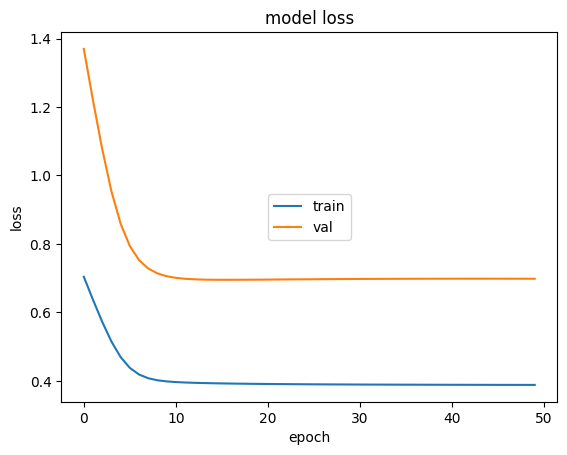

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

### evaluar el modelo

In [25]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3120 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6311
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1314


1.037792682647705

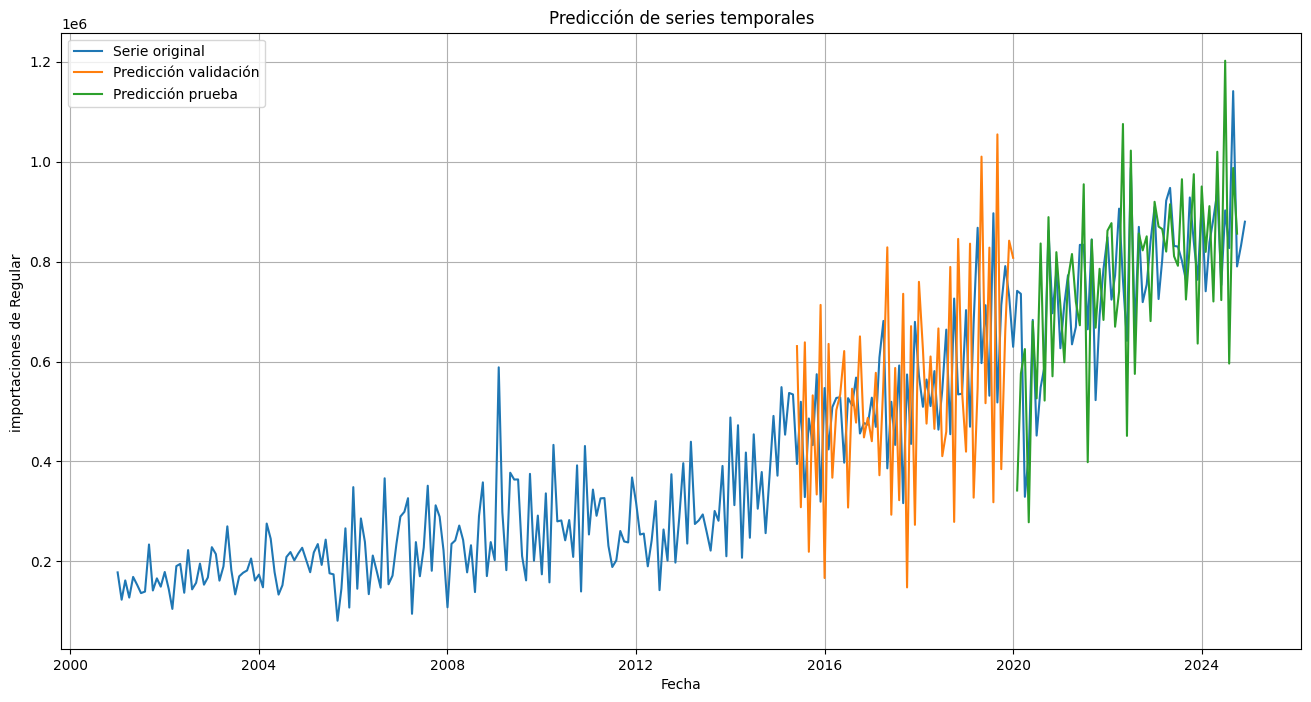

In [26]:
prediccion_val = []
prediccion_val = prediccion_fun(x_val,modelo1,
                                1,
                                scaler,
                                dif=True,dif_cant=1,
                                Series = importaciones_regular_ts.values ,
                                n=train_end)
prediccion_test = prediccion_fun(x_test,modelo1,
                                 1,
                                 scaler,
                                 dif=True,dif_cant=1,
                                 Series = importaciones_regular_ts.values,
                                 n = len(importaciones_regular_ts.values) - len(x_test))



# Set larger figure size (width, height) in inches
plt.figure(figsize=(16, 8))

df_val = pd.DataFrame(prediccion_val, index=importaciones_regular_ts[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test, index=importaciones_regular_ts[val_end:].index[:len(prediccion_test)])

plt.plot(importaciones_regular_ts, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')

plt.legend()
plt.title('Predicción de series temporales')
plt.xlabel('Fecha')
plt.ylabel('importaciones de Regular ')
plt.grid(True)
plt.show()

